# Model Selection Tutorial
このチュートリアルでは、データに最適なモデルを選択するために、さまざまな [Scikit-Learn](http://scikit-learn.org/) モデルのスコアを調べ、[Yellowbrick](http://www.scikit-yb.org/) の視覚的診断ツールを使用してそれらを比較します。

## The Model Selection Triple
機械学習の議論は、多くの場合、モデルの選択に重点が置かれていることが特徴です。
ロジスティック回帰、ランダム フォレスト、ベイジアン手法、人工ニューラル ネットワークのいずれであっても、機械学習の実践者は多くの場合、自分の好みをすぐに表明します。 その理由は主に歴史的なものです。
最新のサードパーティの機械学習ライブラリにより、複数のモデルの展開はほとんど簡単に見えるようになりましたが、従来は、これらのアルゴリズムの 1 つを適用して調整するだけでも、長年の研究が必要でした。
その結果、機械学習の実践者は、他のモデルよりも特定の (そしておそらくより馴染みのある) モデルを強く好む傾向がありました。

ただし、モデルの選択は、単に「正しい」または「間違った」アルゴリズムを選択するよりも少し微妙です。 実際のワークフローには以下が含まれます:

1. 最小かつ最も予測性の高い特徴セットの選択および/またはエンジニアリング
1. モデルファミリーから一連のアルゴリズムを選択し、
1. アルゴリズムのハイパーパラメータを調整してパフォーマンスを最適化します。

**model selection triple**は、Kumar らによる 2015 年の [SIGMOD](http://cseweb.ucsd.edu/~arunkk/vision/SIGMODRecord15.pdf) 論文で初めて説明されました。 予測モデリングを先取りするために構築された次世代データベース システムの開発に関する論文の中で、著者らは、実際の機械学習の非常に実験的な性質のため、そのようなシステムが切実に必要とされていると説得力を持って表現しています。 彼らは、「[モデル選択のトリプル] の空間は通常無限であり、どの [組み合わせ] が満足のいく精度や洞察をもたらすかを分析者が先験的に知ることは一般に不可能であるため、「モデル選択は反復的かつ探索的である」と説明しています。 」

最近、このワークフローの多くは、グリッド検索方法、標準化された API、および GUI ベースのアプリケーションを通じて自動化されています。
ただし、実際には、徹底的な検索よりも人間の直観と導きの方が効果的に高品質のモデルを絞り込むことができます。
モデル選択プロセスを視覚化することで、データ サイエンティストは最終的な説明可能なモデルに向けて舵を切り、落とし穴や罠を回避できます。

Yellowbrick ライブラリは、データ サイエンティストがモデル選択プロセスを制御できるようにする機械学習用の診断視覚化プラットフォームです。
Yellowbrick は、新しいコア オブジェクトである Visualizer を使用して Scikit-Learn API を拡張します。
ビジュアライザーを使用すると、Scikit-Learn パイプライン プロセスの一部としてビジュアル モデルを適合および変換できるようになり、高次元データの変換全体にわたって視覚的な診断が提供されます。

## About the Data
このチュートリアルでは、Yellowbrick [Example Datasets](https://www.scikit-yb.org/en/latest/api/datasets/index.html) モジュールのマッシュルーム データを使用します。
私たちの目的は、キノコの特徴に基づいて、キノコが有毒であるか食用であるかを予測することです。

````
```Note
YB バージョンのキノコ データは、[UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/)のキノコ データセットとは異なります。
Yellowbrick バージョンは、モデリングをもう少し難しくするために意図的に変更されています。
```
````

データには、ハラタケ科およびレピオタ科の 23 種のエラ付きキノコに対応する仮説サンプルの記述が含まれています。
それぞれの種は、明らかに食用であるか、明らかに有毒であるか、または食用性が不明で推奨されないとして識別されました（この後者のクラスは有毒なものと組み合わされました）。

私たちのデータには、8,124 個のキノコ (4,208 個が食用、3,916 個が有毒) の名目上価値のある 3 つの属性と目標値に関する情報が含まれています。

データをロードしましょう:

In [1]:
from yellowbrick.datasets import load_mushroom

X, y = load_mushroom()
print(X[:5]) # inspect the first five rows

    shape surface   color
0  convex  smooth  yellow
1    bell  smooth   white
2  convex   scaly   white
3  convex  smooth    gray
4  convex   scaly  yellow


## Feature Extraction
ターゲットを含む私たちのデータはカテゴリー的なものです。 機械学習のために、これらの値を数値に変更する必要があります。
これをデータセットから抽出するには、scikit-learn トランスフォーマーを使用して入力データセットをモデルに適合できるものに変換する必要があります。
幸いなことに、scikit-learn は、カテゴリラベルを数値整数に変換するためのトランスフォーマー [sklearn.preprocessing.LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) および [sklearn.preprocessing.OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) を提供します。

scikit-learn の ```OneHotEncoder``` と ```LabelEncoder``` である scikit-learn の ```Pipeline``` オブジェクトを組み合わせて使用します ( [ザック・スチュワート](https://twitter.com/zacstewart)によるパイプラインの使用に関する優れた投稿の[リンク](http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html)):

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import  LogisticRegression

# Label-encode targets before modeling
y = LabelEncoder().fit_transform(y)

# Estimator example
estimator = LogisticRegression()

# One-hot encode columns before modeling
model = Pipeline([
 ('one_hot_encoder', OneHotEncoder()),
 ('estimator', estimator)
])

## Modeling and Evaluation

### Common metrics for evaluating classifiers
**precision**(精度) は、正しい陽性結果の数をすべての陽性結果の数で割ったものです (例: 食べられると予測したキノコのうち、実際に食べられるキノコはいくつありましたか?)。

**recall**(再現率) は、正しい陽性結果の数を、返されるべき陽性結果の数で割ったものです (例: 有毒なキノコのうち、有毒であると正確に予測したのは何個ですか?)。

**F1 score**(F1 スコア) は、テストの精度の尺度です。 テストの精度と再現率の両方を考慮してスコアを計算します。 F1 スコアは適合率と再現率の加重平均として解釈でき、F1 スコアは 1 で最高値に達し、0 で最悪値に達します。

```rs
precision = true positives / (true positives + false positives)

recall = true positives / (false negatives + true positives)

F1 score = 2 * ((precision * recall) / (precision + recall))
```

では、いくつかの予測を行う準備が整いました。

複数の推定値を評価する方法を構築しましょう。最初に従来の数値スコアを使用します (後で、Yellowbrick ライブラリのいくつかの視覚的診断と比較します)。

In [3]:
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

models = [
    SVC(gamma = 'auto'), NuSVC(gamma = 'auto'), LinearSVC(),
    SGDClassifier(max_iter = 100, tol = 1e-3), KNeighborsClassifier(),
    LogisticRegression(solver = 'lbfgs'), LogisticRegressionCV(cv = 3),
    BaggingClassifier(), ExtraTreesClassifier(n_estimators = 300),
    RandomForestClassifier(n_estimators = 300)
]


def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
        ('one_hot_encoder', OneHotEncoder()),
        ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)

    expected  = y
    predicted = model.predict(X)

    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {:.3f}".format(estimator.__class__.__name__, f1_score(expected, predicted) ) )

for model in models:
    score_model(X, y, model)

SVC: 0.662
NuSVC: 0.673
LinearSVC: 0.658
SGDClassifier: 0.701


c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


KNeighborsClassifier: 0.658
LogisticRegression: 0.658
LogisticRegressionCV: 0.658
BaggingClassifier: 0.687
ExtraTreesClassifier: 0.687
RandomForestClassifier: 0.687


### Preliminary Model Evaluation
上記の F1 スコアの結果に基づいて、どのモデルが最も優れたパフォーマンスを発揮しているでしょうか?

## Visual Model Evaluation
次に、Yellowbrick の ``ClassificationReport`` クラス (適合率、再現率、F1 スコアを表示するモデル ビジュアライザ) を使用するようにモデル評価関数をリファクタリングしましょう。 この視覚的なモデル分析ツールは、数値スコアと色分けされたヒートマップを統合して、簡単な解釈と検出をサポートします。特に、私たちのユースケースに非常に関連する (人命救助にさえ) タイプ I とタイプ II のエラーの微妙な違いをサポートします。

**Type I error** (または「“false positive”, 偽陽性」) は、存在しない効果を検出することです (例: キノコは実際には食用であるにもかかわらず有毒であると判断する)。

**Type II error** (または「“false negative”, 偽陰性」) は、存在する影響を検出できないことです (例: キノコが実際には有毒であるにもかかわらず、食用であると信じ込むなど)。

SVC: Precision: 0.673, Recall:0.652, F1 score: 0.662


c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


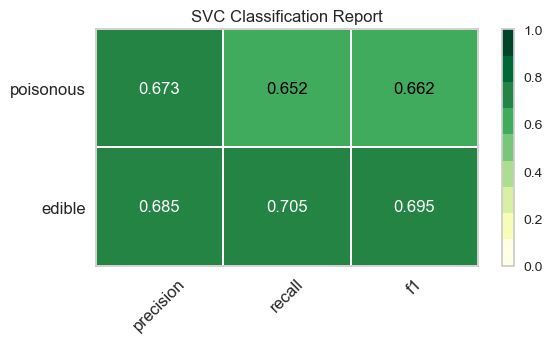

NuSVC: Precision: 0.701, Recall:0.646, F1 score: 0.673


c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


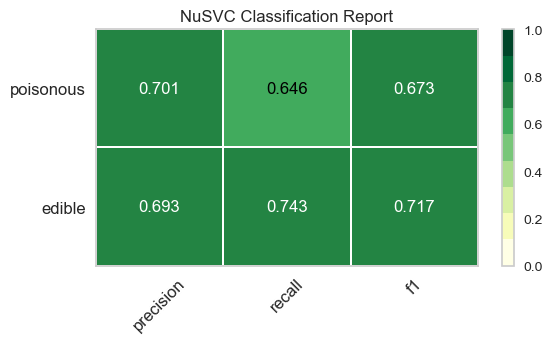

LinearSVC: Precision: 0.647, Recall:0.670, F1 score: 0.658


c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


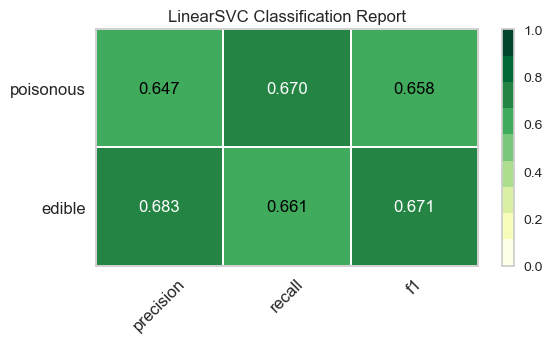

c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


SGDClassifier: Precision: 0.649, Recall:0.722, F1 score: 0.684


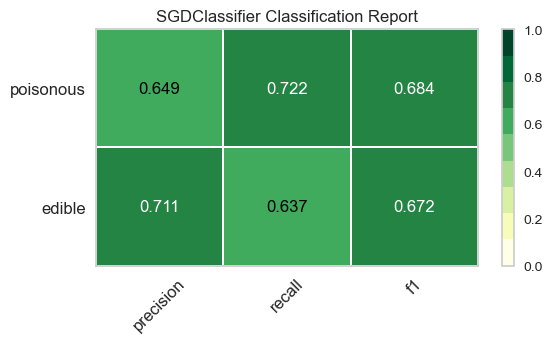

KNeighborsClassifier: Precision: 0.698, Recall:0.623, F1 score: 0.658


c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


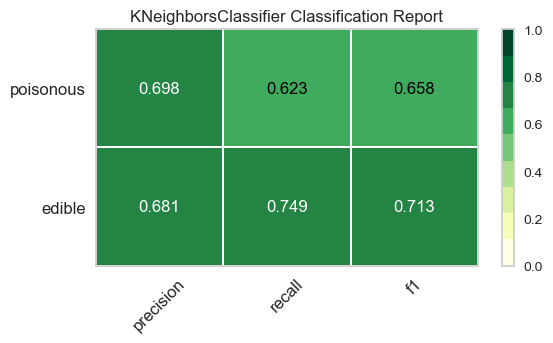

LogisticRegression: Precision: 0.647, Recall:0.669, F1 score: 0.658


c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


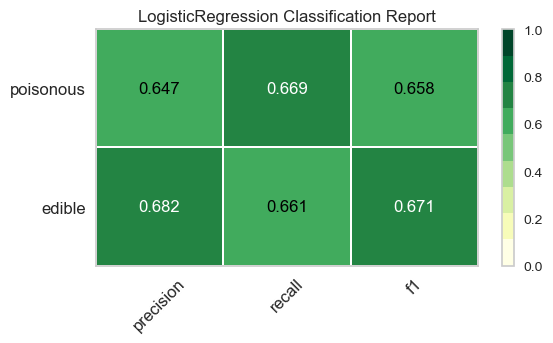

LogisticRegressionCV: Precision: 0.647, Recall:0.670, F1 score: 0.658


c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


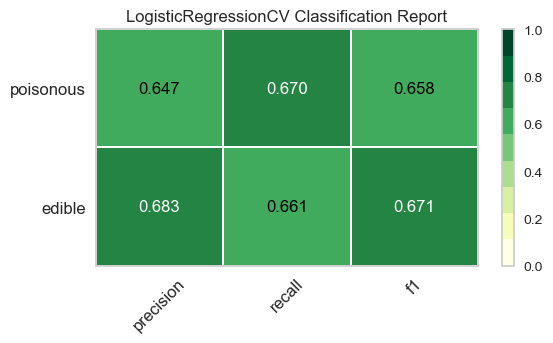

BaggingClassifier: Precision: 0.729, Recall:0.650, F1 score: 0.687


c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


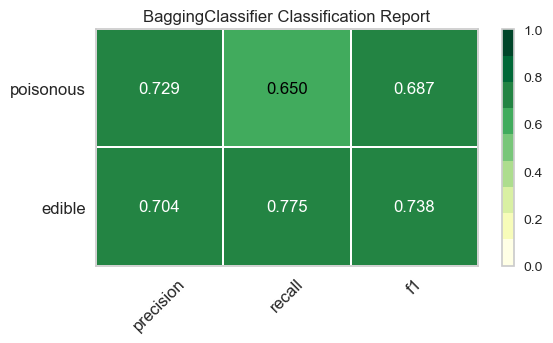

ExtraTreesClassifier: Precision: 0.730, Recall:0.649, F1 score: 0.687


c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


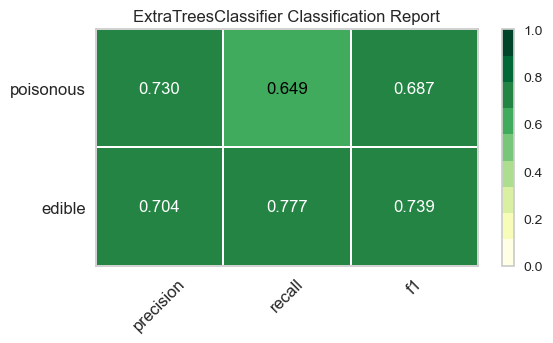

RandomForestClassifier: Precision: 0.730, Recall:0.649, F1 score: 0.687


c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


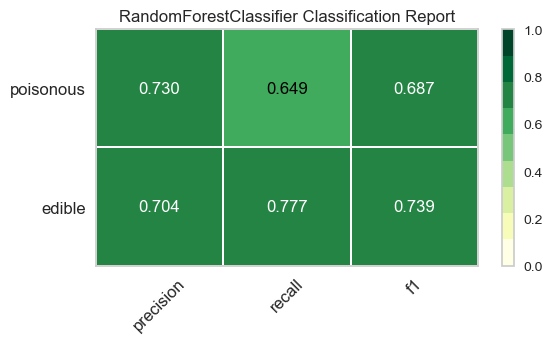

In [4]:
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ClassificationReport

from sklearn.metrics import precision_score, recall_score


def visualize_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
        ('one_hot_encoder', OneHotEncoder()),
        ('estimator', estimator)
    ])

    # sciit-learnのスコア関数との比較を追加する
    model.fit(X, y)
    expected  = y
    predicted = model.predict(X)
    print("{}: Precision: {:.3f}, Recall:{:.3f}, F1 score: {:.3f}".format(
        estimator.__class__.__name__,
        precision_score(expected, predicted),
        recall_score(expected, predicted),
        f1_score(expected, predicted)
        ) )

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model,
        classes = ['edible', 'poisonous'],
        cmap = "YlGn",
        size = (600, 360),
        **kwargs
    )
    visualizer.fit(X, y)
    visualizer.score(X, y)
    visualizer.show()

for model in models:
    visualize_model(X, y, model)

## Reflection
1. 今のところどのモデルが一番良いと思われますか？ なぜ？
1. あなたの命を救う可能性が最も高いのはどれですか?
1. 視覚的なモデル評価エクスペリエンスは数値モデル評価とどのように異なりますか?